In [13]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [14]:
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")


requests        2.32.3
BeautifulSoup   4.12.3


In [15]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [16]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [17]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [18]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [19]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [20]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [21]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [22]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


[People intuitively get slack when they buy from the name brand that offers free returns but is not the lowest cost. Midwit bean counters over-optimize and don't back off from overfitted solutions www.resilience-engineering-association.org/blog/2021/01...](https://www.resilience-engineering-association.org/blog/2021/01/12/slack-a-key-enabler-of-resilient-performance/)

___

You build roads with shoulders, you have 2 means of egress and you do fire drills so there is capacity that doesn't get used every day but is there when you need it.  When you don't have slack in a complex system, it becomes unpredictable or totally breaks down the first time it's overloaded.

You could use AI to run tough simulations of 9/11s and zombie apocalypses and Kobayashi Marus sand have the smartest work force ever. Or you could employ the minimum number of low-wage mouse-clickers to keep AI happy. Until the assumptions of AI no longer hold and it all comes to a sudden stop.

cannot identify image file 'tmp/source3.html; charset=utf-8'


[Why Johnny can't code: Copilot](https://nmn.gl/blog/ai-and-learning) - N’s Blog

___

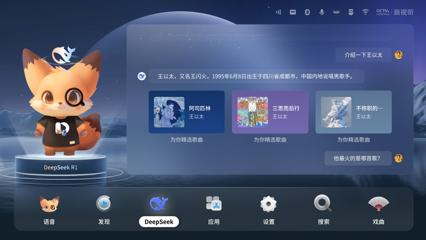

[Chinese companies rush to incorporate DeepSeek in products and online services](https://www.tomshardware.com/tech-industry/artificial-intelligence/chinese-ai-model-deepseek-is-being-integrated-into-smart-tvs-skyworth-g7f-pro-understands-local-dialects-and-generates-multimedia-content) - Tom's Hardware

___

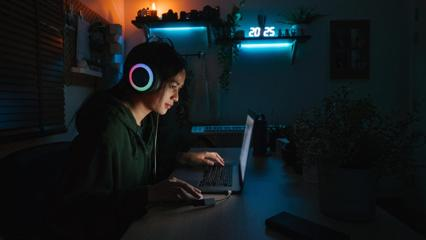

[How to Use AI to Write a Cover Letter](https://www.cnet.com/tech/services-and-software/how-to-use-ai-to-write-a-cover-letter/) - CNET

___

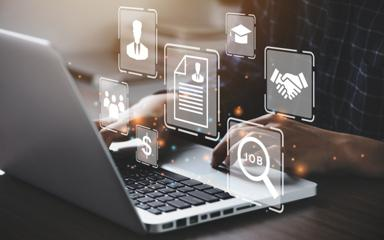

[How candidates can hack HR AI and get hired](https://www.sandiegouniontribune.com/2025/02/17/how-to-unlock-the-secrets-of-ai-and-get-hired/) - San Diego Union-Tribune

___

[How to use AI to find new movies, music, and books](https://www.fastcompany.com/91279431/how-to-use-ai-to-find-new-movies-music-and-books)

___

[AI agents start to talk to customers](https://www.wsj.com/business/ai-agents-customer-service-b4dc99e5)

___

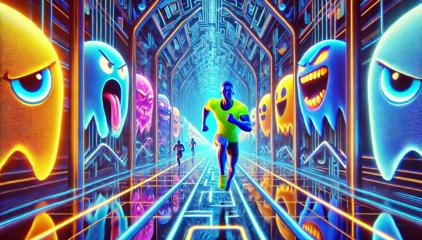

[AI is studying you and learning how to influence you](https://venturebeat.com/ai/like-it-or-not-ai-is-learning-how-to-influence-you/) - VentureBeat

___

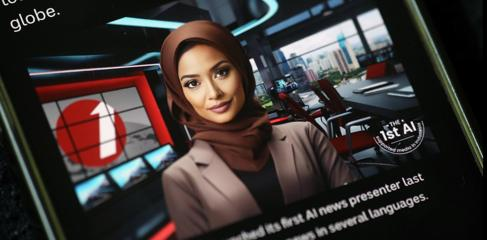

[Generative AI is already being used in journalism, APO report covers use cases and how people feel about them](https://theconversation.com/generative-ai-is-already-being-used-in-journalism-heres-how-people-feel-about-it-247232) - The Conversation

___

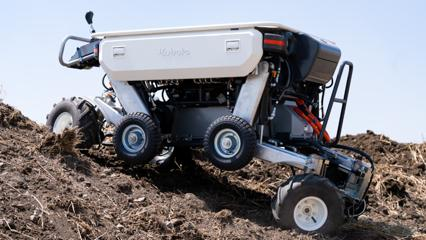

[5 high-tech robots that are changing how we grow our food](https://www.thecooldown.com/green-tech/robotics-agriculture-farming-innovations/) - The Cool Down

___

[New York Times brings an AI tool to its newsroom.

OpenAI lawyers might have some questions about whether it is responsibly sourced.](https://readwrite.com/new-york-times-announces-ai-introduction-to-the-newsroom/)

___

["AI gaydar for middle managers"](https://pluralistic.net/2025/02/17/caliper-ai/#racism-machine)

___

[See also](https://www.reddit.com/r/ChatGPT/comments/1irdxnh/someone_used_ai_to_bring_historical_figures_back/)

___

[Snapchats throughout history](https://www.reddit.com/r/aivideo/comments/1irbmb6/snapchat_throughout_history_a_hilarious_ai_time/)

___

giving AI memory was a bad idea

"You take drugs Danny?"
"Every day"
"Good"

Channeling John Belushi, "my advice to you is to drink heavily"

Criminal life hack, enhance your appearance with AI artifacts so no video evidence of criminal activities will be admissible

[Apple Vision Pro to get Apple Intelligence, Spatial Content App](https://www.bloomberg.com/news/articles/2025-02-15/apple-vision-pro-visionos-2-4-adds-apple-intelligence-spatial-content?sref=10lNAhZ9)

___

cannot identify image file 'tmp/source21.html; charset=utf-8'


[en.wikipedia.org/wiki/Mother,...](https://en.wikipedia.org/wiki/Mother,_Jugs_%26_Speed)

___

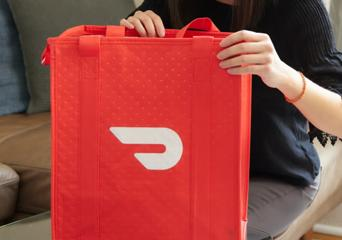

["Mother, Jugs and Speed" except for gig delivery bikers.

You are not expected to get this reference to a 1976 movie with Bill Cosby, Raquel Welch and Harvey Keitel about sketchy ambulance services.](https://www.techspot.com/news/106795-uber-sues-doordash-alleging-anti-competitive-practices-food.html) - TechSpot

___

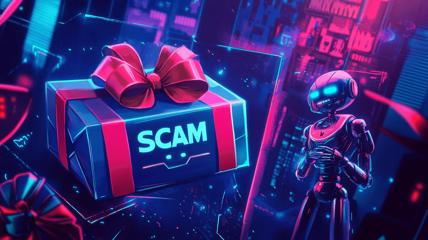

[Jailbreaking AI agents by e.g. sending them to malicious websites with embedded jailbreak instructions.](https://the-decoder.com/ai-agents-can-be-easily-tricked-into-doing-stupid-things-study-says/) - THE DECODER

___

[Meta’s AI-Powered Ray-Bans Are Life-Enhancing for the Blind](https://www.wsj.com/tech/ai/metas-ai-powered-ray-bans-are-life-enhancing-for-the-blind-3ae38026?mod=tech_lead_story)

___

[Microsoft OmniParser can watch your screen and talk to e.g. your own local LLM model for agentic behavior](https://www.microsoft.com/en-us/research/articles/omniparser-v2-turning-any-llm-into-a-computer-use-agent/)

___

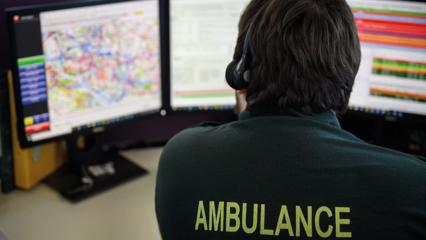

[The jobs AI can do — and those it shouldn’t

also high stakes vs. low stakes decisions, deciding whether to do a major surgery or play Russian Roulette or fire missiles is a trap-door one-way decision, whether to watch the Americans or Better Caul Saul, you could change your mind after 5 minutes](https://www.ft.com/content/9b34b76c-938b-4de4-838f-9c6ef506da19)

___

[be nice to AI and maybe it will be nice later!](https://www.reddit.com/r/ChatGPT/comments/1iqu2i1/i_always_say_please_and_thank_you_to_chatgpt/)

___

[Can AI read your dog’s facial expressions?](https://www.science.org/content/article/can-ai-read-pain-and-other-emotions-your-dog-s-face)

___

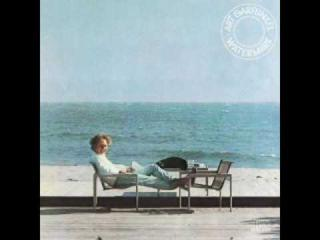

[Happy Sunday

Art Garfunkel, Paul Simon, James Taylor - (What A) Wonderful World](https://www.youtube.com/watch?v=f-s9uXvwrws) - YouTube

___

[Pie in the sky AI vs down to earth AI](https://www.reuters.com/breakingviews/ais-civil-war-will-force-investors-pick-sides-2025-02-07/)

___

- no child process may be aborted but asynchronous processes must be killed
- no garbage collection, memory managed by the state, who controls the past controls the future
- true is false and false is true

sorry

in the fascist programming language

- all objects inherit from trump master class (no inheritance tax)
- equality tests are a runtime error
- no imports or foreign keys
- no syntax error if it's saving the country

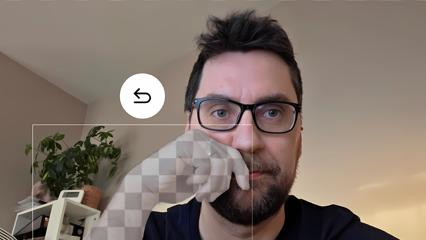

[Samsung magic face reconstruction](https://www.androidauthority.com/samsung-face-generation-ai-3525494/) - Android Authority

___

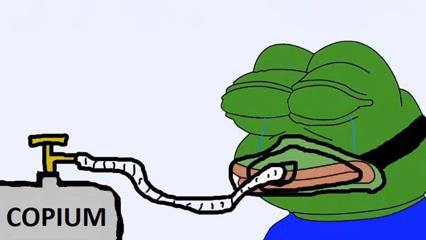

[We will not be replaced. Hopefully. Yet.](https://marioarias.hashnode.dev/no-your-genai-model-isnt-going-to-replace-me) - Uncle Mario's ramblings

___

Trust me bro, all I need is another $10b

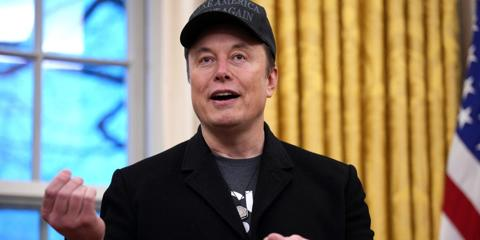

[Monday Grok 3 demo, which I'm sure will be entirely free of unwarranted hype](https://www.businessinsider.com/elon-musk-xai-chatbot-grok-3-released-monday-ai-2025-2) - Business Insider

___

[Some people seem to like the GPT-4o update, some stuff doesn't work anymore, recheck all your agents and rankings I guess](https://x.com/emollick/status/1890856663738925545) - X (formerly Twitter)

___

[Srinivas and Altman in X tit-for-tat](https://x.com/sama/status/1890818803438698677) - X (formerly Twitter)

___

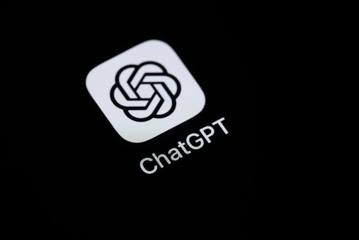

[Death of OpenAI whistleblower deemed suicide in final official autopsy report](https://techcrunch.com/2025/02/15/death-of-openai-whistleblower-deemed-suicide-in-new-autopsy-report/) - TechCrunch

___

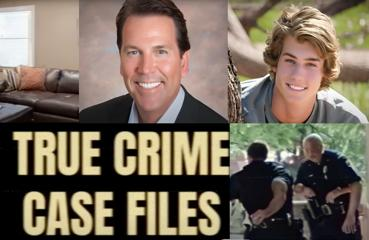

[A ‘True Crime’ Documentary Series Has Millions of Views. The Murders Are All AI-Generated](https://www.404media.co/a-true-crime-documentary-series-has-millions-of-views-the-murders-are-all-ai-generated/) - 404 Media

___

I mean, the ranking could get manipulated. 

only billions get bet on the Super Bowl, not like anyone would be incentivized for a Black Sox type deal with some Bitcoin money laundering

[You can now bet on which will top Chatbot Arena kalshi.com/markets/kxto...

not like markets could be manipulated or anything, or anyone is going to pretend to police it 🙄](https://kalshi.com/markets/kxtopmodel/top-model)

___

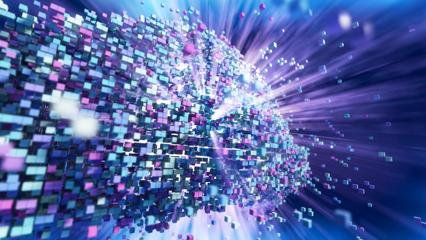

[Galileo which I guess is an agent evaluation and iteration platform, ranks LLMs for agentic use cases.](https://www.zdnet.com/article/which-ai-agent-is-the-best-this-new-leaderboard-can-tell-you/) - ZDNET

___

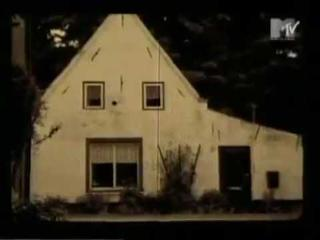

[\\$10b here, \\$10b there, pretty soon you're talking about real money](https://www.youtube.com/watch?v=04qPdGNA_KM) - YouTube

___

[Musk looking to raise another \\$10b for xAI](https://www.reuters.com/technology/artificial-intelligence/musks-xai-talks-raise-10-billion-75-billion-valuation-bloomberg-news-reports-2025-02-14/)

___

[Apple's Siri AI overhaul hits snags, possible delay until May](https://www.bloomberg.com/news/articles/2025-02-14/apple-s-long-promised-ai-overhaul-for-siri-runs-into-bugs-possible-delays?embedded-checkout=true)

___

[Perplexity offers free(mium) Deep Research](https://www.perplexity.ai/hub/blog/introducing-perplexity-deep-research)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [23]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [12]:
print(datetime.now())

2024-11-23 10:09:59.450305


In [13]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 11, 23, 15, 8, 24, 139000)

In [14]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-11-22 04:09:59.456685


In [15]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [16]:
a

{'x': 1, 'y': 2}

In [17]:
b



NameError: name 'b' is not defined